# IBM Capstone Project: The Battle of the Neighborhoods
## Open new Turkish Restaurant in Bucharest, Romania

## Introduction

In this project, I will determine which place is good for opening Turkish Restaurant in Bucharest, Romania 

* I will convert address data into their equivalent latitude and longitude values. 
* For Bucharest neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts of Bucharest
* I will use the Foursquare API to explore Bucharest neighborhoods and to get venues in neighborhoods. 
* I will use the Foursquare API to get venue ratings and likes in neighborhoods. 
* I will use the *k*-means clustering and Agglomerative algorithms to complete clustering task
* I will use the Folium library to visualize the neighborhoods, venues , clusters in Bucharest


## Table of Contents

1. <a href="#item1">Download and Explore Neigborhood Dataset</a>
2. <a href="#item2">Load and Analyze Venues of Neighborhoods in Bucharest</a>
3. <a href="#item3">Cluster Neighborhoods using Agglomerative Clustering</a> <br> 
4. <a href="#item4">Discussion</a>
5. <a href="#item5">Conclusion</a>    

<a id='item1'></a>
## 1. Download and Explore Neigborhood Dataset

#### Import Libraries

In [2]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

In [3]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


#### Get geocoordinates of Bucharest, Romania

In [4]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


#### Get neighborhood data of Bucharest

I used wikiPedia, "Category:Districts of Bucharest" for getting neighborhoods of Bucharest . 

In [5]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))


There are 40 neighborhoods in Bucharest, Romania


#### Get sector of neighborhood and population of sector

In [6]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector


There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,453"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


#### Set sector of neighborhoods 

In [7]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,453"
1,Băneasa,Sector 1,"225,453"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,453"
4,Centrul Civic,Sector 3,"385,439"


#### Get geographical coordinates of neighborhoods
I use python geocoder library to get geograpical coordinates of neighborhoods

In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,453",44.485790,26.101219
1,Băneasa,Sector 1,"225,453",44.493952,26.080518
2,Berceni,Sector 4,"287,828",44.386430,26.128490
3,Bucureștii Noi,Sector 1,"225,453",44.480413,26.042807
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094670


#### Create Bucharest map with neighborhoods superimposed
Let's see locations of neighborhoods on map. In here, I use folium library to draw map

In [9]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

<a id='item2'></a>
# 2. Load Venues and Analyze Neighborhoods in Bucharest

We will use Foursquare API for getting venues of neighborhoods

#### Explore Venues of Bucharest neighborhoods
I get venue list with 1 km distance to neighborhood's center

In [10]:
# @hidden_cell
CLIENT_ID = 'PR4BTKNRIZEBQKKAW45YMI4R0E0J12EG1LBMSHSQFPGQTHLB' # your Foursquare ID
CLIENT_SECRET = 'KDJBDP01YBJ5JIH2IGFVR2V2T02AF4RNSCT45EL5LZRO32OL' # your Foursquare Secret
VERSION = '201091002'

CLIENT_ID = 'S1KVEF2AKPAYLU1ETMETRFO3R0FWOUJXWWGQ55TILVFOAOLY' # your Foursquare ID
CLIENT_SECRET = 'G1EAHHBTQRSOP4JVOIQBM4QV452XF5JZBLV04MV0CSPKJLAF' # your Foursquare Secret
VERSION = '20180605'


In [11]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 225 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
2,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint
3,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
4,Aviației,44.48579,26.101219,Mega Image,4eb5452b30f8d0f18c41dfec,44.487255,26.092758,691,Supermarket


In [14]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,76
Restaurant,72
Italian Restaurant,63
Coffee Shop,54
Supermarket,53
Pizza Place,51
Gym,41
Hotel,40
Romanian Restaurant,36


#### Filter restaurants out of all venues
Let's filter venues and get only restaurants 

In [12]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))


Total number of restaurants: 502
Total number of Turkish restaurants: 21
Percentage of Turkish restaurants: 4.18%


19 neighborhoods do not have any Turkish restaurant


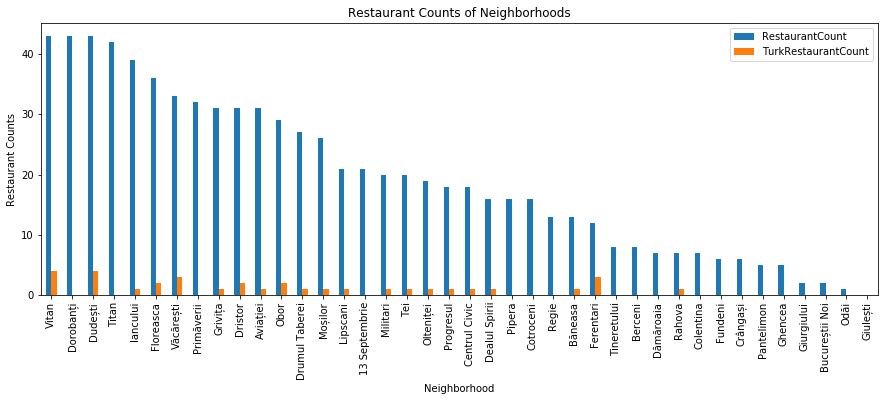

In [13]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()



We can see from the Graph :
* Vitan is the neihgborhood having most restaurants
* Dorobanti is has lots of restaurants , but no Tukish restaurant
* Odai and Gluesti are neihgborhoods having least number of restaurants
* 19 neihgborhoods do not have any Turkish restaurant. we can choose one of these to open resaturant. To filter more let's continue

#### Get the restaurant's overall rating

I used Foursquare API for getting likes and rates of restaurants 

In [14]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,8.3,22.0
1,53623e44498ed583ede334f5,8.2,130.0
2,55b8a459498efbbb6ca3526d,7.7,8.0
3,58bbf8764f1069627380fed5,7.7,21.0
4,59162d2d2be42556981e1e4a,7.6,68.0


In [15]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,8.3,22.0
1,Floreasca,44.476308,26.103289,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,351,Burger Joint,8.3,22.0
2,Aviației,44.485790,26.101219,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,8.2,130.0
3,Floreasca,44.476308,26.103289,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,230,Restaurant,8.2,130.0
4,Aviației,44.485790,26.101219,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,7.7,8.0


In [16]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,7.3,12.0
1,Floreasca,44.476308,26.103289,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,251,Turkish Restaurant,7.3,12.0
2,Băneasa,44.493952,26.080518,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,56,Doner Restaurant,7.3,40.0
3,Centrul Civic,44.434300,26.094670,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,661,Doner Restaurant,7.9,466.0
4,Lipscani,44.432155,26.104057,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,379,Doner Restaurant,7.9,466.0


#### Show restaurants on head map 

Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Bucharest on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Bucharest center

Red markers are Turkish restaurants

Blue markers are Turkish restaurants with rating less than 7 restaurants


In [17]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

From heat map , we can see that there are 
* Too many restaurants in 4 km to the center 
* Enough restaurants between 4-6 km to the center 
* There are <b> not many </b> restaurants after <b> 6 km to center </b> 
* Turkish restaurants are superimposed with red and blue dots. Blue dots are Turkish restaurant with raiting <7 
* <b> Turkish restaurants are located in South, North , East, between 2-4 Km distance around center </b>
* There are <b> not Turkish Restaurants in West Part.</b>
* 3 Turkish restaurants gets bad points. That means people does not prefer these restaurant too much and any turkish restaurant may be opened around

#### Show neighborhoods which has no Turkish restaurant on head map 

Cyan markers are Neigborhoods without any turkish restaurants

In [18]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

<a id='item3'></a>
# 3. Cluster Neigborhoods using Agglomerative Clustering

In [36]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 225 columns as below


,Neighborhood,Supermarket,Burger Joint,Coffee Shop,Dessert Shop,Beer Garden,Roof Deck,Restaurant,Grocery Store,Gym / Fitness Center,Shopping Mall,Bookstore,Hotel,Candy Store,Vietnamese Restaurant,Café,Pie Shop,Bakery,Salon / Barbershop,Salad Place,Clothing Store,Sushi Restaurant,Steakhouse,Italian Restaurant,Turkish Restaurant,Toy / Game Store,Sandwich Place,Pizza Place,Middle Eastern Restaurant,Lebanese Restaurant,Casino,Spanish Restaurant,Spa,Event Space,Fried Chicken Joint,Veterinarian,Lounge,Chinese Restaurant,Romanian Restaurant,Pub,Stadium,Metro Station,Tennis Stadium,Mongolian Restaurant,Eastern European Restaurant,Men's Store,Cocktail Bar,Donut Shop,Nightclub,Comfort Food Restaurant,Gym,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Theme Restaurant,Tunnel,Farmers Market,Bed & Breakfast,Airport Terminal,Bus Stop,Food & Drink Shop,Indoor Play Area,Nature Preserve,Fruit & Vegetable Store,Fast Food Restaurant,Electronics Store,Jewelry Store,Fountain,Department Store,Gas Station,Mobile Phone Shop,Korean Restaurant,Shop & Service,Gastropub,Outdoor Sculpture,Indie Theater,Theater,Monastery,Bistro,Skating Rink,Ice Cream Shop,Historic Site,Used Bookstore,Chocolate Shop,Plaza,Art Museum,Bar,Palace,Wine Bar,Beer Bar,Hookah Bar,Concert Hall,Tea Room,Rock Club,Cosmetics Shop,Hostel,Art Gallery,Music Venue,Boutique,Swiss Restaurant,History Museum,Mediterranean Restaurant,Hardware Store,Discount Store,Bus Station,Gift Shop,Pharmacy,Tennis Court,Jazz Club,Accessories Store,Opera House,Market,Hotel Bar,Indian Restaurant,Pedestrian Plaza,Music Store,Garden,Pool,Indie Movie Theater,Australian Restaurant,Soccer Field,Shoe Store,Light Rail Station,Scenic Lookout,Cupcake Shop,French Restaurant,Climbing Gym,Soccer Stadium,Bowling Alley,Smoke Shop,Convenience Store,Furniture / Home Store,Outlet Mall,Flower Shop,Japanese Restaurant,Juice Bar,Fish Market,Scandinavian Restaurant,Cheese Shop,Asian Restaurant,Modern European Restaurant,Creperie,Seafood Restaurant,Molecular Gastronomy Restaurant,Wine Shop,German Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Greek Restaurant,Intersection,Kids Store,Water Park,Brewery,Playground,Butcher,Health Food Store,American Restaurant,Diner,Auto Dealership,Health & Beauty Service,Science Museum,Lingerie Store,Ramen Restaurant,Cafeteria,Cable Car,Sports Club,Museum,Food Truck,Arts & Crafts Store,Movie Theater,Bagel Shop,Kebab Restaurant,Exhibit,Public Art,Snack Place,Tattoo Parlor,Sporting Goods Shop,Gourmet Shop,Karaoke Bar,Church,Hospital,Women's Store,Irish Pub,Breakfast Spot,Camera Store,Bridal Shop,BBQ Joint,Hungarian Restaurant,Beach,Auto Garage,Food Court,Athletics & Sports,Food,Go Kart Track,IT Services,Track,Gym Pool,Recreation Center,Bike Shop,Basketball Court,Paper / Office Supplies Store,Pool Hall,Sports Bar,Laundromat,Baby Store,Buffet,Taco Place,Fish & Chips Shop,Watch Shop,Recording Studio,ATM,Soup Place,Circus,Falafel Restaurant,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Cultural Center,Dog Run,Tram Station
0,13 Septembrie,1,0,2,0,0,0,5,0,2,0,0,3,0,0,4,0,0,0,0,2,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,2,0,2,3,0,0,0,0,1,0,1,0,0,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,4,1,1,1,0,0,0,0,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,Aviației,4,3,3,1,1,1,4,1,1,1,1,4,1,1,5,1,5,1,1,3,2,3,1,1,1,1,4,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berceni,0,0,1,0,1,0,0,2,2,

In [41]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,69,Restaurant,Plaza,Café,Hotel,Pub,Seafood Restaurant,Tea Room,Comfort Food Restaurant,Romanian Restaurant,Lounge
1,Aviației,80,Café,Bakery,Restaurant,Pizza Place,Hotel,Supermarket,Burger Joint,Steakhouse,Coffee Shop,Clothing Store
2,Berceni,27,Pizza Place,Eastern European Restaurant,Electronics Store,Farmers Market,Grocery Store,Gym / Fitness Center,Gym,Fruit & Vegetable Store,Clothing Store,Metro Station
3,Bucureștii Noi,14,Gym,Park,Supermarket,Spa,Metro Station,Shop & Service,Korean Restaurant,Mobile Phone Shop,Department Store,Gas Station
4,Băneasa,30,Park,Hotel,Romanian Restaurant,Airport Terminal,Restaurant,Café,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Nightclub


#### Cluster and find similarities between neighborhoods

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

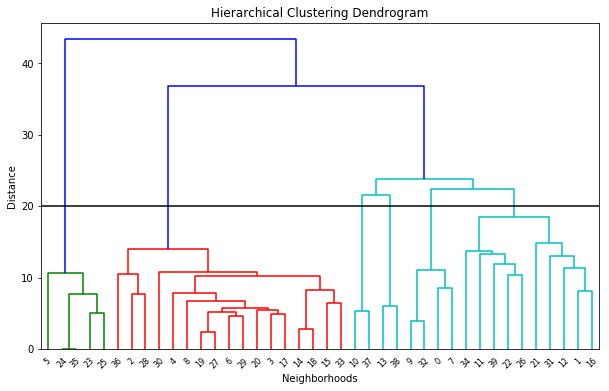

In [53]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 6 clusters (cut at distance of 20, horizontal black line). 
I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [58]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,453",44.485790,26.101219,0,Café,Bakery,Restaurant
1,Băneasa,Sector 1,"225,453",44.493952,26.080518,2,Park,Hotel,Romanian Restaurant
2,Berceni,Sector 4,"287,828",44.386430,26.128490,2,Pizza Place,Eastern European Restaurant,Electronics Store
3,Bucureștii Noi,Sector 1,"225,453",44.480413,26.042807,2,Gym,Park,Supermarket
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094670,3,Coffee Shop,Hotel,Theater


In [84]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [83]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   Café                                         1
                    Coffee Shop                                  2
                    Italian Restaurant                           2
                    Lounge                                       1
                    Pizza Place                                  1
                    Pub                                          1
                    Supermarket                                  2
1                   Café                                         1
                    Restaurant                                   3
2                   Burger Joint                                 1
                    Bus Station                                  1
                    Café                                         2
                    Clothing Store                            

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                     
0                   Bakery                                        2
                    Burger Joint                                  1
                    Café                                          2
                    Gym                                           2
                    Italian Restaurant                            1
                    Pizza Place                                   1
                    Supermarket                                   1
1                   Bus Station                                   2
                    Hotel                                         1
                    Plaza                                         1
2                   Bar                                           2
                    Bus Station                                   1
                    Café                                          1
                    Clothing Store                                1
                    Dessert Shop                                  1
                    Eastern European Restaurant                   3
                    Hotel                                         1
                    Museum                                        1
                    Park                                          2
                    Pizza Place                                   1
                    Pool                                          1
                    Pub                                           1
                    Restaurant                                    1
3                   Café                                          1
                    Hotel                                         3
                    Pub                                           1
4                   Supermarket                                   2
5                   Coffee Shop                                   2

#### We can see cluster categories as below  <br>
Cluster 0 (Red)     : Italian Restaurant , Pizza, Café  <br>
Cluster 1 (Purple)  : Restaurant , Bar <br>
Cluster 2 (BLue)    : Park , Plaza, Clothing stores  <br>
Cluster 3 (Cyan)    : Coffee Shop, Hotel, Pub <br>
Cluster 4 (Green)   : Café, Suprmarket <br>
Cluster 5 (Orange)  : Café <br>

<a id='item4'></a>
## 4. Discussion 

Cluster 2 suffers from restaurant. Especially there is no Turkish restaurant in west part inluding Cluster 2 . We can think about Cluster 2 , West part

Cluster 0 especially likes Itallian tastes , may be this part will not like Turkish tastes . We can only think about 1 location may be .

Cluster 1, 2, 3 are centers full of restaurants as we saw in the heatmap also


<a id='item5'></a>
## 5. Conclusion

Possible Neighborhoods to set up a Turkish restaurant :


•	Neighborhood : Regie ,  Cluster 0, Sector 6 , Population : 367760      

    I choosed Regie , since west part of Bucharest has not Turkish restaurant and Regie is close to center . Regie is red cluster which is same with the other 2 red markers having Turk restaurant. Red clusters populations may like Turkish food. 

•	Neighborhood : Bucureștii Noi ,  Cluster 2,  Sector 1 , Population : 225453

    I choosed Bucharest-noi , since west part of Bucharest has not Turkish restaurant and even not too much restaurant after 6 km distance to center . One restaurant will be good for this area.

•	Neighborhood : Crângași ,  Cluster 2,  Sector 6 , Population : 367760

    I choosed Crangasi , since Crangasi  and west part of Bucharest has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. Also this neighborhood is in Sector 6 and this sector has biggest population which will handle one more restaurant 

•	Neighborhood : Tineretului ,  Cluster 2,  Sector 4 , Population : 287828

    I choosed Tineretului , since Tineretului has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. 



        